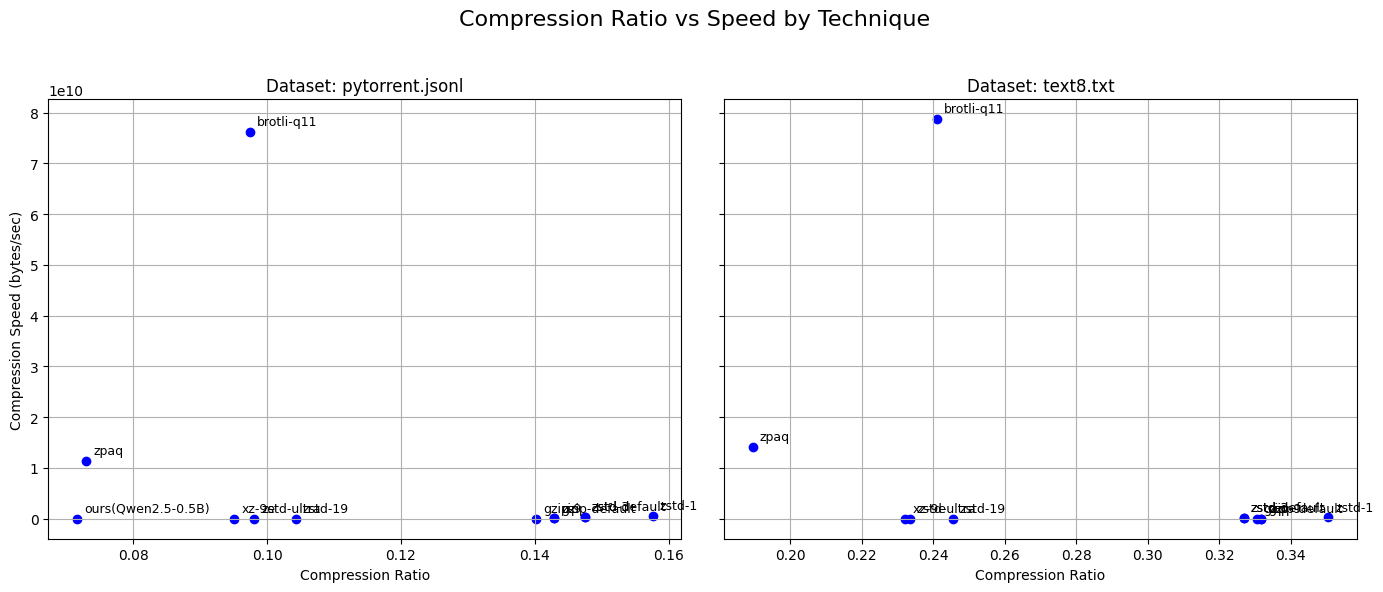

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv('competitors.csv')

# Compute metrics
df['compression_ratio'] = df['Compressed Size'] / df['Dataset Size']
df['compression_speed'] = df['Dataset Size'] / df['Compression Duration']

# Get unique datasets
datasets = df['Dataset'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(datasets), figsize=(14, 6), sharey=True)

# Ensure axes is iterable
if len(datasets) == 1:
    axes = [axes]

# Plot per dataset
for ax, dataset in zip(axes, datasets):
    subset = df[df['Dataset'] == dataset]
    ax.scatter(subset['compression_ratio'], subset['compression_speed'], color='blue')

    # Add annotations
    for _, row in subset.iterrows():
        ax.annotate(row['Technique'],
                    (row['compression_ratio'], row['compression_speed']),
                    textcoords="offset points",
                    xytext=(5,5),
                    ha='left',
                    fontsize=9)

    ax.set_title(f'Dataset: {dataset.split("/")[-1]}')
    ax.set_xlabel('Compression Ratio')
    ax.grid(True)

axes[0].set_ylabel('Compression Speed (bytes/sec)')
fig.suptitle('Compression Ratio vs Speed by Technique', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

25000.0


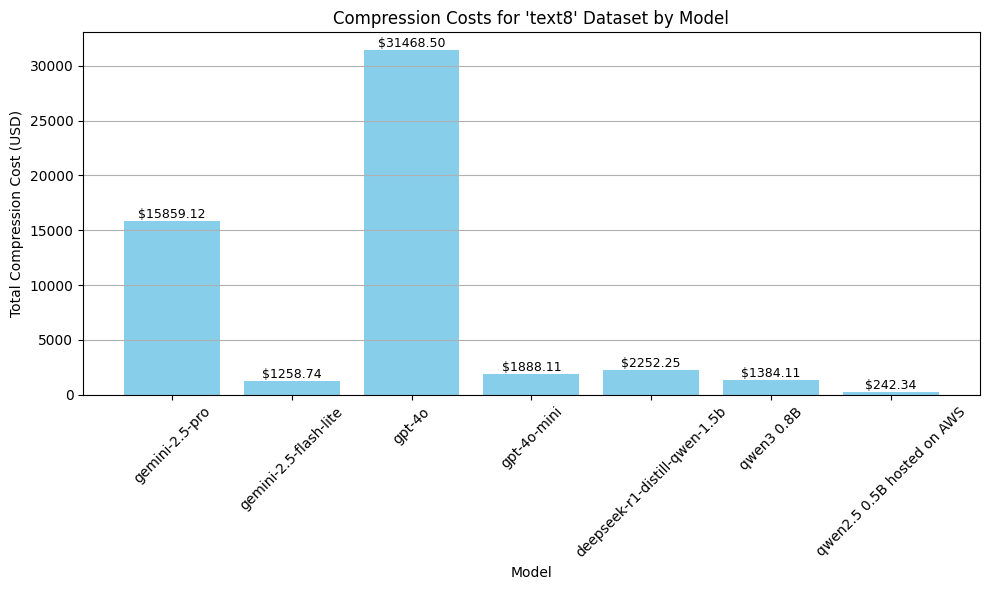

In [3]:
import matplotlib.pyplot as plt

# Configuration
output_token_per_chunk = 999
input_tokens_per_chunk = 499500
total_tokens = 25_000_000  # size of text8 dataset, just approximate

qwen25_compression_seconds_per_chunk = 18.7516143293 # approx.
aws_instance_price_per_hour = 1.861 # g6e.xlarge

# Cost per 1 million tokens (USD)
model_costs = {
    "gemini-2.5-pro": {"input": 1.25, "output": 10.0},
    "gemini-2.5-flash-lite": {"input": 0.1, "output": 0.4},
    "gpt-4o": {"input": 2.5, "output": 10.0},
    "gpt-4o-mini": {"input": 0.15, "output": 0.60},
    "deepseek-r1-distill-qwen-1.5b": {"input": 0.18, "output": 0.18},
    "qwen3 0.8B": {"input": 0.11, "output": 0.42},
}

# Compute number of chunks
num_chunks = total_tokens / 1000
print(num_chunks)

# Calculate total cost per model
costs = {}
for model, rates in model_costs.items():
    total_cost = (((input_tokens_per_chunk * num_chunks) / 1000000) * rates["input"]) + (((output_token_per_chunk * num_chunks) / 1000000) * rates["output"])
    costs[model] = total_cost

costs['qwen2.5 0.5B hosted on AWS'] = (num_chunks * qwen25_compression_seconds_per_chunk) / 60 / 60 * aws_instance_price_per_hour

# Plotting
models = list(costs.keys())
values = list(costs.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, values, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Total Compression Cost (USD)")
plt.title("Compression Costs for 'text8' Dataset by Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.05,
        f"${yval:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/631799338.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(text8_df['Technique'], rotation=45, ha='right', fontsize=7)
/var/folders/95/xqt0fs314pdc538zdd7m_gym0000gn/T/ipykernel_83892/631799338.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(pytorrent_df['Technique'], rotation=45, ha='right', fontsize=7)


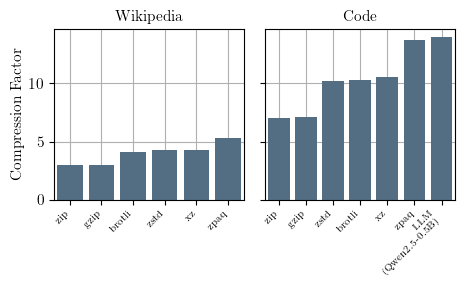

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Which techniques to include in the plot from the CSV file. Also rename them for better readability.
technique_includelist = {
    'none': 'none',
    'zip': 'zip',
    'gzip-9': 'gzip',
    'zstd-ultra': 'zstd',
    'xz-9e': 'xz',
    'brotli-q11': 'brotli',
    'zpaq': 'zpaq',
    'ours(Qwen2.5-0.5B)': 'LLM\n(Qwen2.5-0.5B)',
}

df = pd.read_csv('competitors.csv')
df = df[df['Technique'].isin(technique_includelist.keys())]
df['Technique'] = df['Technique'].map(technique_includelist)
df['Compression Factor'] = df['Dataset Size'] / df['Compressed Size']
df = df.sort_values(by='Compression Factor', ascending=True)
text8_df = df[df['Dataset'] == 'data/text8.txt']
pytorrent_df = df[df['Dataset'] == 'data/pytorrent.jsonl']

matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif', 'axes.titlesize': 'medium', 'figure.titlesize': 'medium', 'text.usetex': True, 'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}\\usepackage{siunitx}[=v2]', 'pgf.rcfonts': False, 'pgf.texsystem': 'pdflatex'})
fig, axes = plt.subplots(1, 2, figsize=(4.9, 3.0), sharey=True)
# Compression factor for text8
sns.barplot(x='Technique', y='Compression Factor', data=text8_df, ax=axes[0], color='#4B6F8A')
axes[0].set_title('Wikipedia')
axes[0].set_xticklabels(text8_df['Technique'], rotation=45, ha='right', fontsize=7)
axes[0].grid(zorder=0)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('')  # Remove x-axis label

# Compression factor for pytorrent
sns.barplot(x='Technique', y='Compression Factor', data=pytorrent_df, ax=axes[1], color='#4B6F8A')
axes[1].set_title('Code')
axes[1].set_xticklabels(pytorrent_df['Technique'], rotation=45, ha='right', fontsize=7)
axes[1].grid(zorder=0)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()